# Titanic with random forests

Looking at the [titanic](https://www.kaggle.com/competitions/titanic) kaggle competition using random forests.

## Data

In [1]:
from fastai.imports import *

frames = pd.read_csv("data/titanic/train.csv")
test_frames = pd.read_csv("data/titanic/test.csv")
modes = frames.mode().iloc[0]

In [2]:
# Split frames into train and validation
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
train_frames, val_frames = train_test_split(frames, test_size=0.25)

In [3]:
# Lets list our different variables and how we will treat them

cats = ["Sex", "Embarked"]  # Categorical
conts = ["Age", "SibSp", "Parch", "LogFare", "Pclass"]  # Continuous, node Pclass is in here
dep = "Survived"  # Dependent

In [4]:
# Process the data
# Random forests dont need dummy variables so we convert them to pandas categorical vars
# This is just a number with a lookup back to the string, we then use that the replace the numbers


def process_data(frames):
    frames["Fare"] = frames.Fare.fillna(0)
    frames.fillna(modes, inplace=True)
    frames["LogFare"] = np.log1p(frames.Fare)
    frames["Embarked"] = pd.Categorical(frames.Embarked)
    frames["Sex"] = pd.Categorical(frames.Sex)

    frames[cats] = frames[cats].apply(lambda x: x.cat.codes)


process_data(train_frames)
process_data(val_frames)
process_data(test_frames)

train_frames.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
298,299,1,1,"Saalfeld, Mr. Adolphe",1,24.00,0,0,19988,30.5000,C106,2,3.449988
884,885,0,3,"Sutehall, Mr. Henry Jr",1,25.00,0,0,SOTON/OQ 392076,7.0500,B96 B98,2,2.085672
247,248,1,2,"Hamalainen, Mrs. William (Anna)",0,24.00,0,2,250649,14.5000,B96 B98,2,2.740840
478,479,0,3,"Karlsson, Mr. Nils August",1,22.00,0,0,350060,7.5208,B96 B98,2,2.142510
305,306,1,1,"Allison, Master. Hudson Trevor",1,0.92,1,2,113781,151.5500,C22 C26,2,5.027492


## Binary splits

Random forests are build from decision trees, to make a decision tree we need to create a binary split.

A binary split is where you group rows based on if they are above or below some threshold of some column. eg. Male/Female. In our data set a lot more women (70%) survived than men (20%). So we could make a model that just says all women survive.

How good would this model be?

In [5]:
from sklearn.metrics import mean_absolute_error


# Function to split out indeps (x) and dependent (y) vars as separate tuples
def get_xy(frame):
    x = frame[cats + conts].copy()
    y = frame[dep] if dep in frame else None
    return x, y


train_x, train_y = get_xy(train_frames)
val_x, val_y = get_xy(val_frames)

In [6]:
# Apparently not that bad
preds = val_x.Sex == 0
mean_absolute_error(val_y, preds)

0.21524663677130046

What about splitting on a continuous column like LogFare. Did people who paid more survive more?

In [7]:
# Less good but not that bad
thresh = 2.7  # Avg of survivors was 2.5
preds = val_x.LogFare > thresh
mean_absolute_error(val_y, preds)

0.336322869955157

In [8]:
# Lets find a way to score any split
# The score will be how well the split creates 2 groups that are similar/dissimilar
# We'll get the std deviation of the dep var of the each side of the split


def side_score(side, y):
    total = side.sum()
    if total <= 1:
        return 0

    return y[side].std() * total


def score(col, y, split):
    lhs = col <= split
    rhs = ~lhs

    return (side_score(lhs, y) + side_score(rhs, y)) / len(y)


# The scores match our previous manual results
score(train_x["Sex"], train_y, 0.5), score(train_x["LogFare"], train_y, 2.7)

(0.40787530982063946, 0.47180873952099694)

In [9]:
# Pop it in a GUI
from ipywidgets import interact
from fastai.vision.widgets import *


def getScore(nm, split):
    col = train_x[nm]
    return score(col, train_y, split)


interact(nm=conts, split=15.5)(getScore), interact(nm=cats, split=2)(getScore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

In [10]:
# That is fun but impractical, lets write a function to find the best split point for every indepenent var and tell us its score
def best_score(frames, col_name):
    # Pull the single column
    x = frames[col_name]
    y = frames[dep]

    # All possible split points
    split_points = x.dropna().unique()

    # Calc score at every split
    scores = np.array([score(x, y, point) for point in split_points if not np.isnan(point)])

    # Find th best (min) score
    best_idx = scores.argmin()

    return split_points[best_idx], scores[best_idx]


best_score(train_frames, "Age")

(6.0, 0.478316717508991)

In [11]:
# We can calculate this for all of the columns
{name: best_score(train_frames, name) for name in cats + conts}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

Turns out we picked the best the first time around with Sex.

This is pretty much a reinvention of the [OneR classifier](https://link.springer.com/article/10.1023/A:1022631118932), a decision tree with a single split. In the 90's this turned out to be one of the most effective classifiers in real-world datasets.

## Decision trees

What if we do more than one split? Take each of our two groups from Sex and split each of them. We will down want to just pick the next best field we want to find the best split for males and the best split for females.

In [18]:
split2_cols = cats + conts
split2_cols.remove("Sex")
is_male = train_frames.Sex == 1

males, females = train_frames[is_male], train_frames[~is_male]

In [17]:
# For males the next best predictor is age
{name: best_score(males, name) for name in split2_cols}

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

In [20]:
# For females the next best predictor is Pclass
{name: best_score(females, name) for name in split2_cols}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

We could keep going down this route but sklearn does this for us. Here is the same thing that we have just manually done.

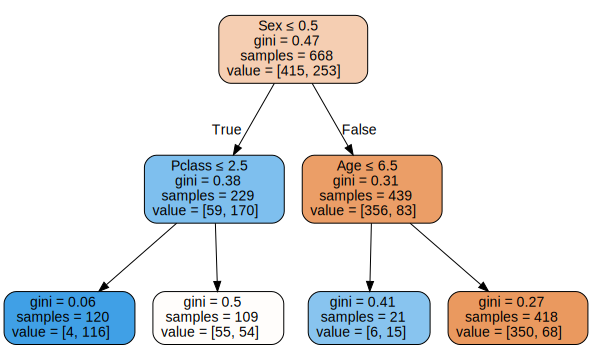

In [32]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz


def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s = export_graphviz(
        t,
        out_file=None,
        feature_names=df.columns,
        filled=True,
        rounded=True,
        special_characters=True,
        rotate=False,
        precision=precision,
        **kwargs,
    )

    return graphviz.Source(re.sub("Tree {", f"Tree {{ size={size}; ratio={ratio}", s))


dec_tree = DecisionTreeClassifier(max_leaf_nodes=4).fit(train_x, train_y)

draw_tree(dec_tree, train_x)

gini is an alternative to our score. Its the probability that if you pick two rows from a group you'll get the same survived result each time. 1 is all the same, 0 if they are all different. If they are an equal mix then 0.5 etc.

How does this compare to our OneR?

In [33]:
mean_absolute_error(val_y, dec_tree.predict(val_x))

0.2242152466367713

In [35]:
?help

Signature:   help(*args, **kwds)
Type:        _Helper
String form: Type help() for interactive help, or help(object) for help about object.
Namespace:   Python builtin
File:        /usr/lib/python3.10/_sitebuiltins.py
Docstring:  
Define the builtin 'help'.

This is a wrapper around pydoc.help that provides a helpful message
when 'help' is typed at the Python interactive prompt.

Calling help() at the Python prompt starts an interactive help session.
Calling help(thing) prints help for the python object 'thing'.

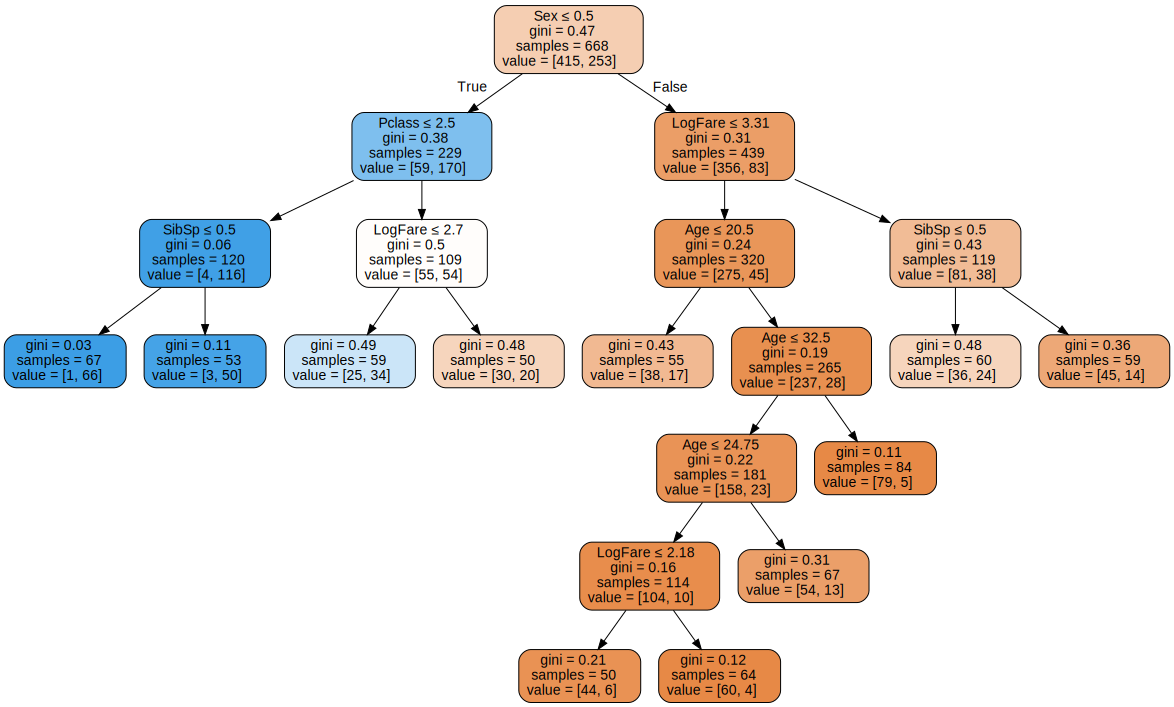

In [56]:
big_tree = DecisionTreeClassifier(min_samples_leaf=50)
big_tree.fit(train_x, train_y)

draw_tree(big_tree, train_x, size=30)

In [59]:
# Hurray this looks a better
mean_absolute_error(val_y, big_tree.predict(val_x))

0.18385650224215247

## Random forests

We can't make our decision tree much bigger as some of the lead nodes already have only 50 rows, so we don't have much data to make a prediction. What if we want bigger trees through?

We could make lots of trees and take the average of them. Taking the average prediction of a bunch of models in this way is called bagging.

We want each models predictions to be uncorrelated with each other, so that when we average them the average of lots of uncorrelated random errors is zero.

One way to to this is to train each model on a random subset of the training data.

In [73]:
def get_tree(prop=0.75):
    N = len(train_y)
    idxs = random.choice(N, int(N * prop))

    return DecisionTreeClassifier(min_samples_leaf=5).fit(train_x.iloc[idxs], train_y.iloc[idxs])


trees = [get_tree() for t in range(100)]

# Get predictions from each tree
probs = [t.predict(val_x) for t in trees]

# Average the predictions
avg_probs = np.stack(probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.22327354260089682

This is pretty much a random forest. a real random forest also selects a random subset of columns for each split:

In [76]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(100, min_samples_leaf=5)
forest.fit(train_x, train_y)

mean_absolute_error(val_y, forest.predict(val_x))

0.18834080717488788

Random forests can help tell us what the most "important" independent variables are.

In [82]:
[x for x in zip(train_x.columns, forest.feature_importances_)]

[('Sex', 0.4437085082236096),
 ('Embarked', 0.0316349804218781),
 ('Age', 0.14194091499778674),
 ('SibSp', 0.03515837543626088),
 ('Parch', 0.027179369847107306),
 ('LogFare', 0.20355409738412028),
 ('Pclass', 0.11682375368923718)]